# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fes_1d(data,sim_parameters,params="^cv"):
    #-- estimation of Free Energy Surface --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
    ax.grid()
    plt.tight_layout()
    ax.set_xlabel(r"$(cv1,cv2)$")
    ax.set_ylabel("FES [Kj/mol]")

    plt.show()

def fes_2d(data,sim_parameters,params="^cv"):
    #-- 2D plot --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig,ax_scatter = plt.subplots(1,1,figsize=(10,8))
    
    fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
    bounds = np.arange(0, 60, 5.)
    cmap = plt.cm.get_cmap('fessa',len(bounds))
    colors = list(cmap(np.arange(len(bounds))))
    cmap = mpl.colors.ListedColormap(colors[:-1], "")
    # set over-color to last color of list 
    cmap.set_over("white")
    c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
    )
    c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    ax_scatter.legend(["FES [Kj/mol]"])
    c.clabel()
    ax_scatter.grid()
    ax_scatter.set_xlabel(r"$CV1$")
    ax_scatter.set_ylabel(r"$CV2$")

# Simulation parameters 

In [3]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
folder = "unbias_A/"
# simulated data from unbias simulation
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
# benchmark data for comparison
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

# Different lags $\Delta \lambda$

In [4]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':5,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#

In [5]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,25]
timescale = np.empty(len(lags))
for i,lag in enumerate(lags):
    train_parameters["lag_time"] = lag
    print("lag time ", lag)
    torch.manual_seed(21)
    model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

    #-- move the model back to cpu for convenience --# 
    model.to('cpu')

    #-- print some useful results --#
    print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
    print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
    print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])
    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]

lag time  1
no weights
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.416      -1.415      0.776  0.640  
INFO: Early stopping
688   -1.423      -1.419      0.780  0.644  
timescales:  [4.016343  2.2702541]
eigenvalues:  [0.77959347 0.6437278 ]
gap:  0.13586569
lag time  2
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
367   -1.111      -1.090      0.667  0.444  
timescales:  [4.9452405 2.4625325]
eigenvalues:  [0.66735756 0.4438929 ]
gap:  0.22346467
lag time  3
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
299   -0.952      -0.939      0.597  0.354  
timescales:  [5.8224516 2.8854513]
eigenvalues:  [0.5973531 0.3535612]
gap:  0.24379191
lag time  4
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
267   -0.773      -0.763      0.536  0.230  
timescales:  [6.404789 2.722107]
eigenvalues:  [0.5355116  0.23005198]
gap:  0.30545962
lag time  5
no weights


In [6]:
timescale2 = np.empty(len(lags))
for i,lag in enumerate(lags):
    train_parameters["lag_time"] = lag
    print("lag time ", lag)
    torch.manual_seed(501)
    model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

    #-- move the model back to cpu for convenience --# 
    model.to('cpu')

    #-- print some useful results --#
    print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
    print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
    print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])
    timescale2[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]

lag time  1
no weights
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.422      -1.407      0.777  0.645  
INFO: Early stopping
667   -1.430      -1.412      0.781  0.649  
timescales:  [4.0449324 2.310006 ]
eigenvalues:  [0.7809666 0.6486258]
gap:  0.13234079
lag time  2
no weights
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.118      -1.093      0.673  0.445  
INFO: Early stopping
607   -1.128      -1.103      0.678  0.450  
timescales:  [5.138553 2.502867]
eigenvalues:  [0.6775888 0.4497409]
gap:  0.22784793
lag time  3
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
326   -0.942      -0.941      0.583  0.359  
timescales:  [5.558786 2.926158]
eigenvalues:  [0.58293116 0.3587121 ]
gap:  0.22421905
lag time  4
no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
348   -0.775      -0.761      0.537  0.235  
timescales:  [6.429094  2.7626143]
eigenvalues:  [0.5367775 0.2350625]
g

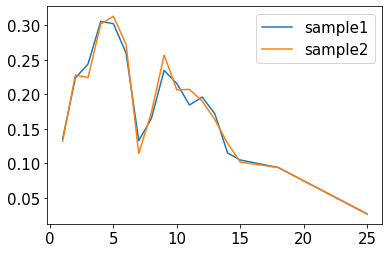

In [7]:
plt.plot(lags,timescale,label="sample1")
plt.plot(lags,timescale2,label="sample2")
plt.legend()

# Seed = 4045

## DeepTICA Analysis and Export

In [8]:
train_parameters["lag_time"] = 4 #10 è quello usato nella simulazione
# append models for comparison
models = []
torch.manual_seed(4045)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = "test_different_seeds/lag"+str(train_parameters["lag_time"])+"/deeptica_seed"+str(4025)+"/"    
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
401   -0.773      -0.764      0.541  0.231  
already exists
model saved
timescales:  [6.517503 2.729414]
eigenvalues:  [0.5413269  0.23095876]
gap:  0.31036812


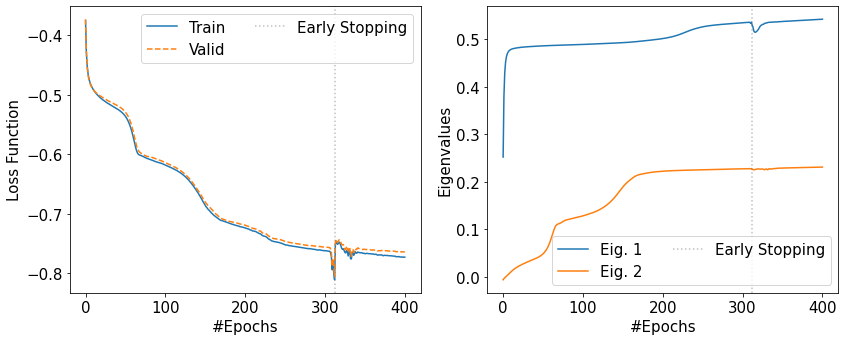

In [9]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [10]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

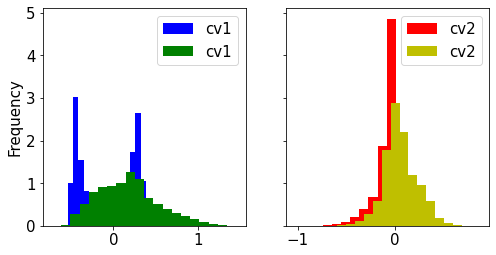

In [11]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

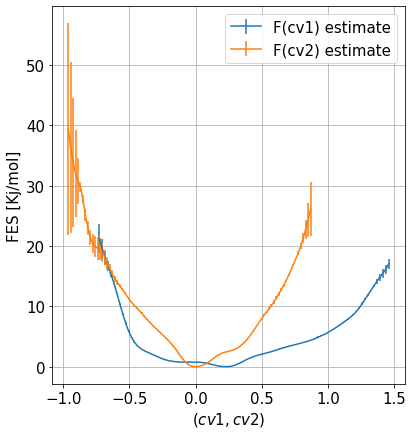

In [12]:
fes_1d(data_complete,sim_parameters)

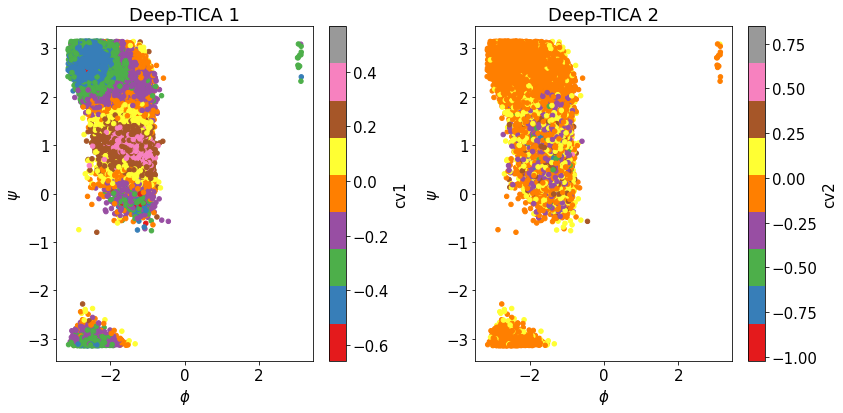

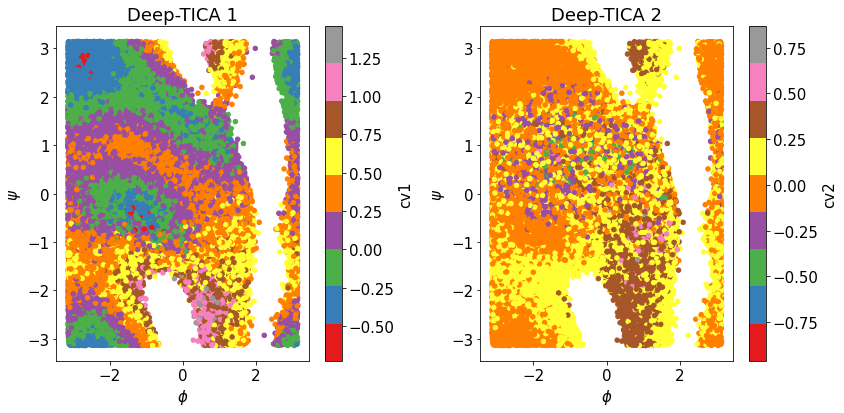

In [13]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [14]:
Boltzmann_product(model,model,X,j=0,k=1)

0.0035074694277814926

# Seed = 35

## DeepTICA Analysis and Export

In [15]:
torch.manual_seed(35)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = "test_different_seeds/lag"+str(train_parameters["lag_time"])+"/deeptica_seed"+str(21)+"/"    
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
305   -0.782      -0.789      0.542  0.231  
already exists
model saved
timescales:  [6.525955  2.7328217]
eigenvalues:  [0.54175735 0.23138122]
gap:  0.3103761


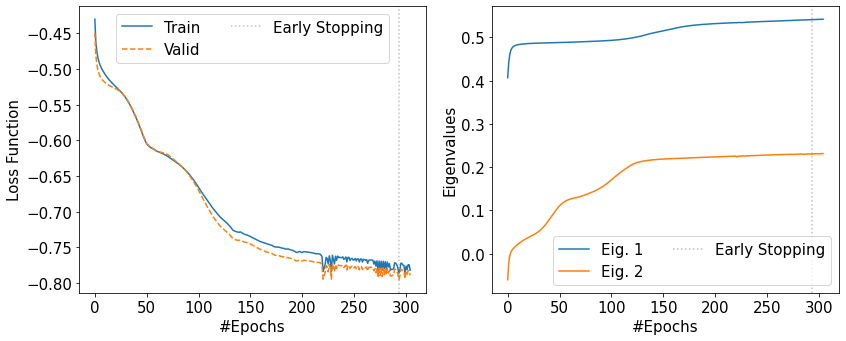

In [16]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [17]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

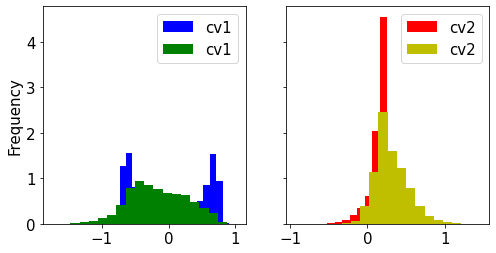

In [18]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

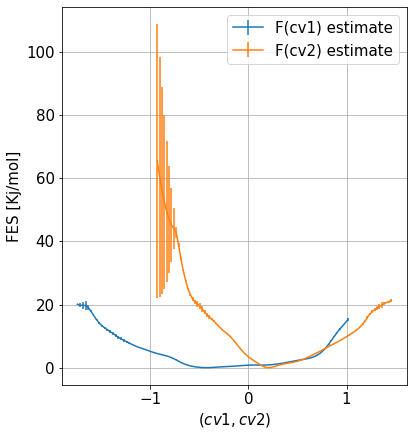

In [19]:
fes_1d(data_complete,sim_parameters)

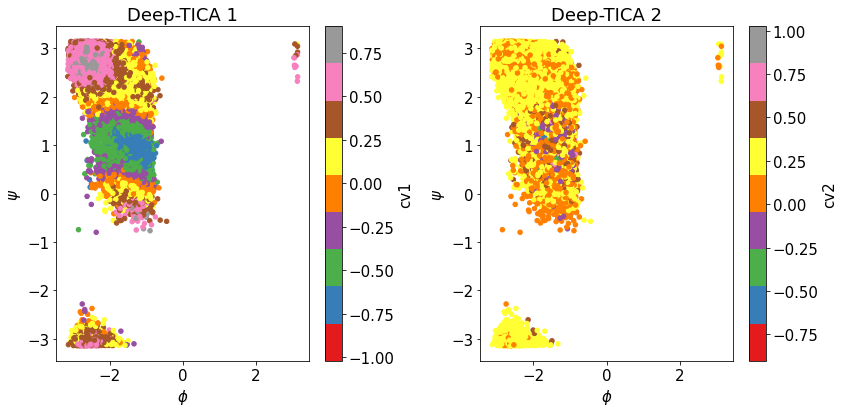

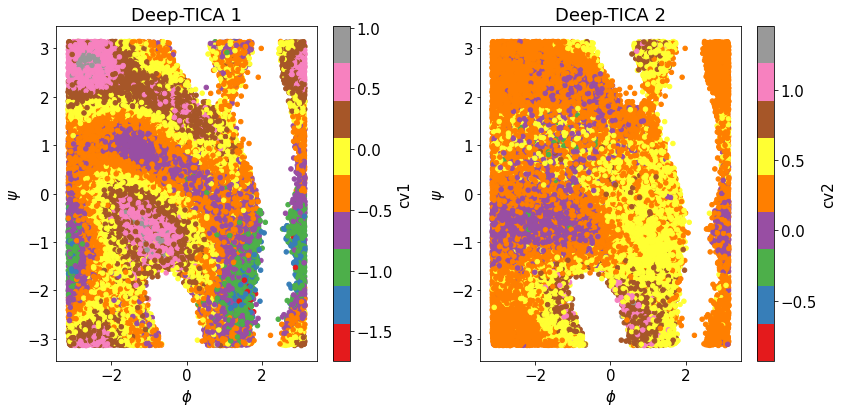

In [20]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [21]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.004526749876997062

# seed = 151

## DeepTICA Analysis and Export

In [22]:
torch.manual_seed(151)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = "test_different_seeds/lag"+str(train_parameters["lag_time"])+"/deeptica_seed"+str(151)+"/"    
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
402   -0.768      -0.764      0.536  0.232  
already exists
model saved
timescales:  [6.4162197 2.7348254]
eigenvalues:  [0.5361078  0.23162949]
gap:  0.3044783


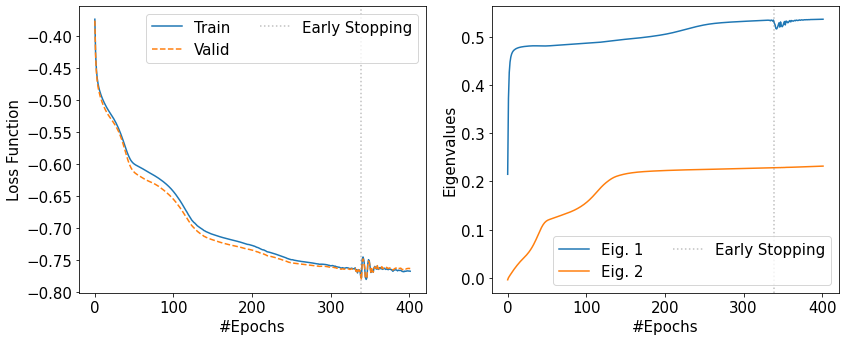

In [23]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [24]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

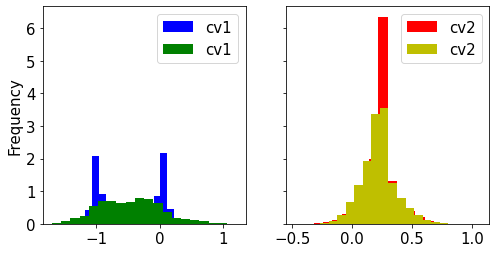

In [25]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

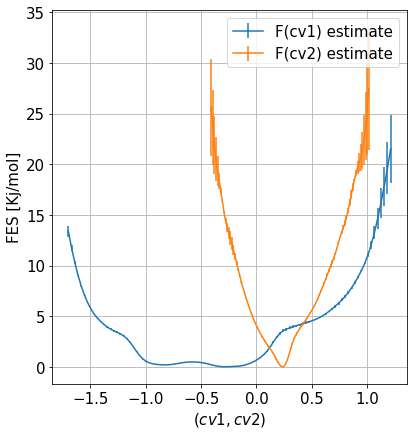

In [26]:
fes_1d(data_complete,sim_parameters)

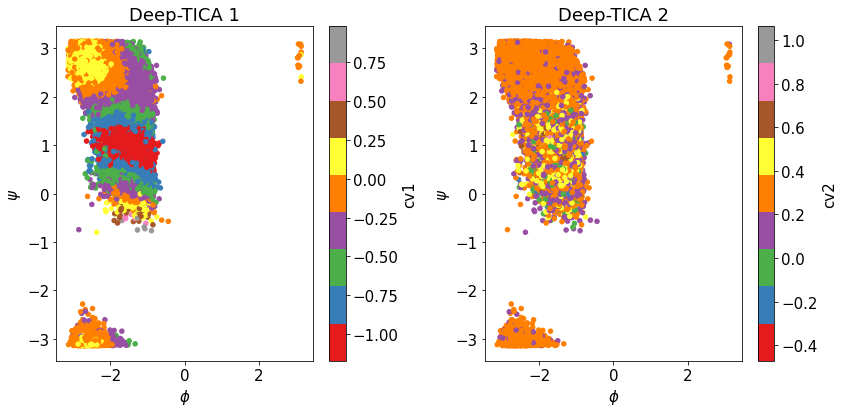

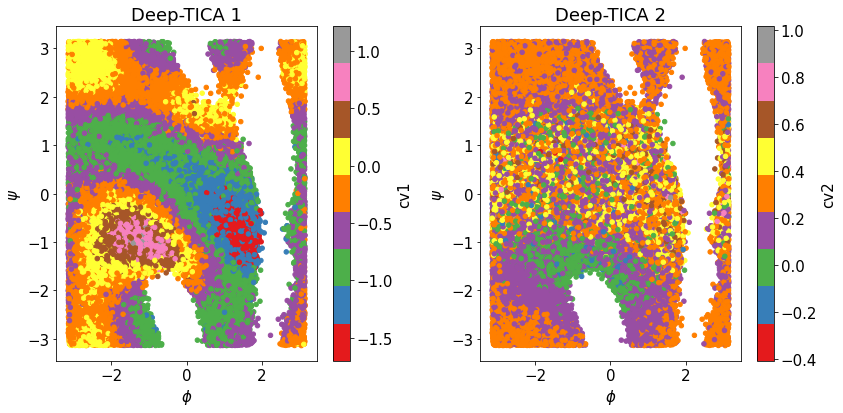

In [27]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [28]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.11248920153196494

# Seed = 500

## DeepTICA Analysis and Export

In [29]:
torch.manual_seed(500)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = "test_different_seeds/lag"+str(train_parameters["lag_time"])+"/deeptica_seed"+str(500)+"/"    
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

no weights
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
297   -0.766      -0.772      0.533  0.232  
already exists
model saved
timescales:  [6.365053  2.7366464]
eigenvalues:  [0.53342783 0.23185503]
gap:  0.3015728


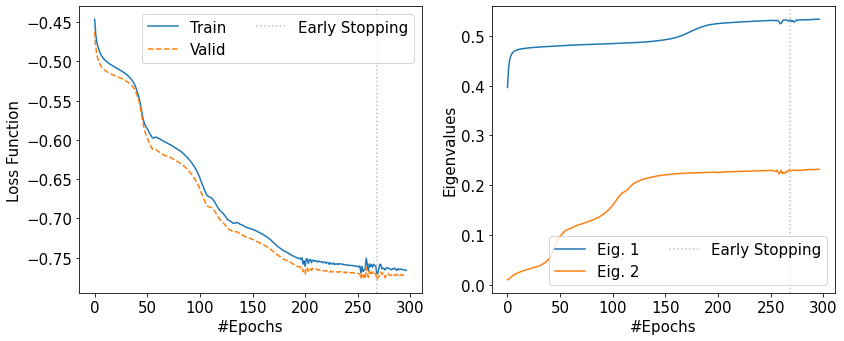

In [30]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [31]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

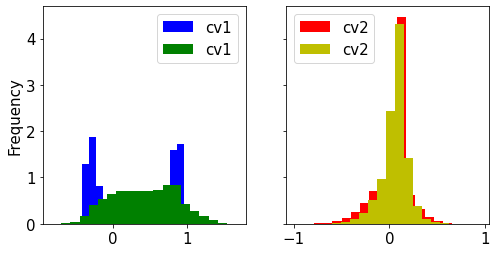

In [32]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

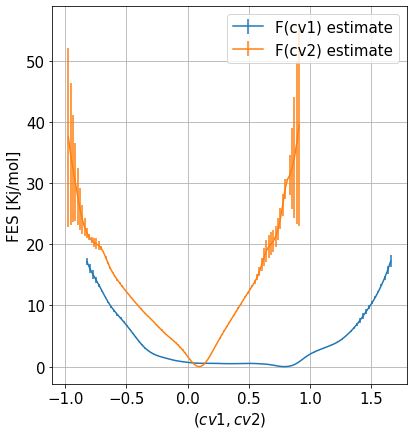

In [33]:
fes_1d(data_complete,sim_parameters)

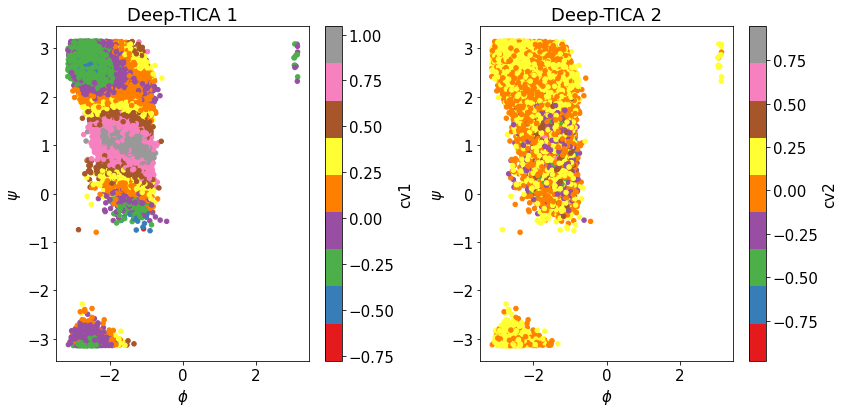

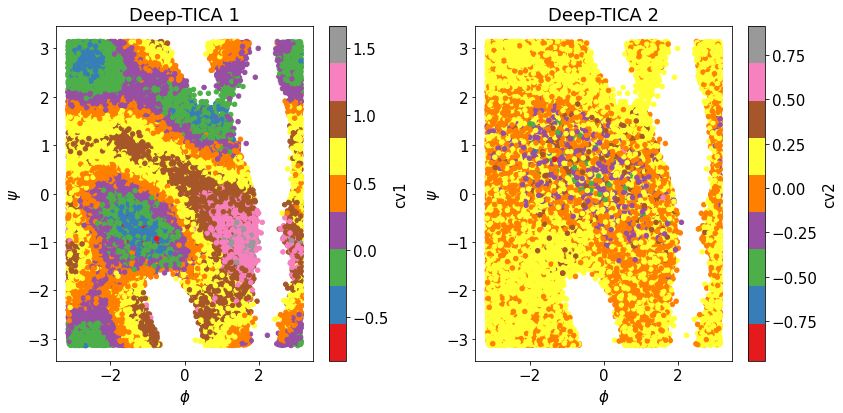

In [34]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [35]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.014633536645517538

# Plot all Deep-TICAs
## Deep-TICA 1

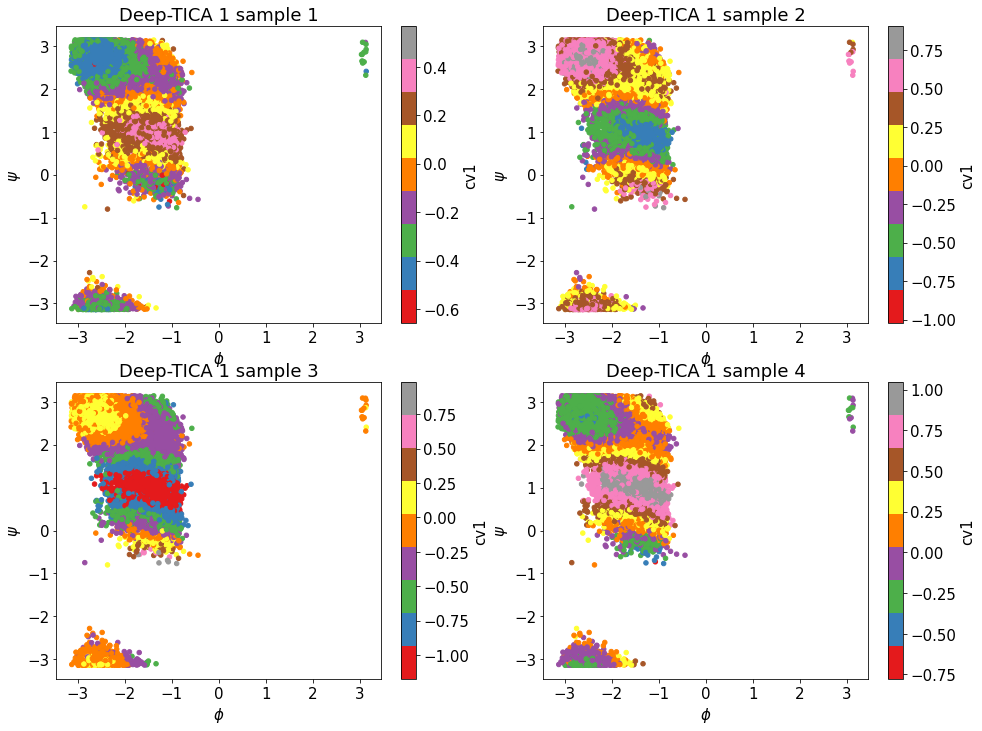

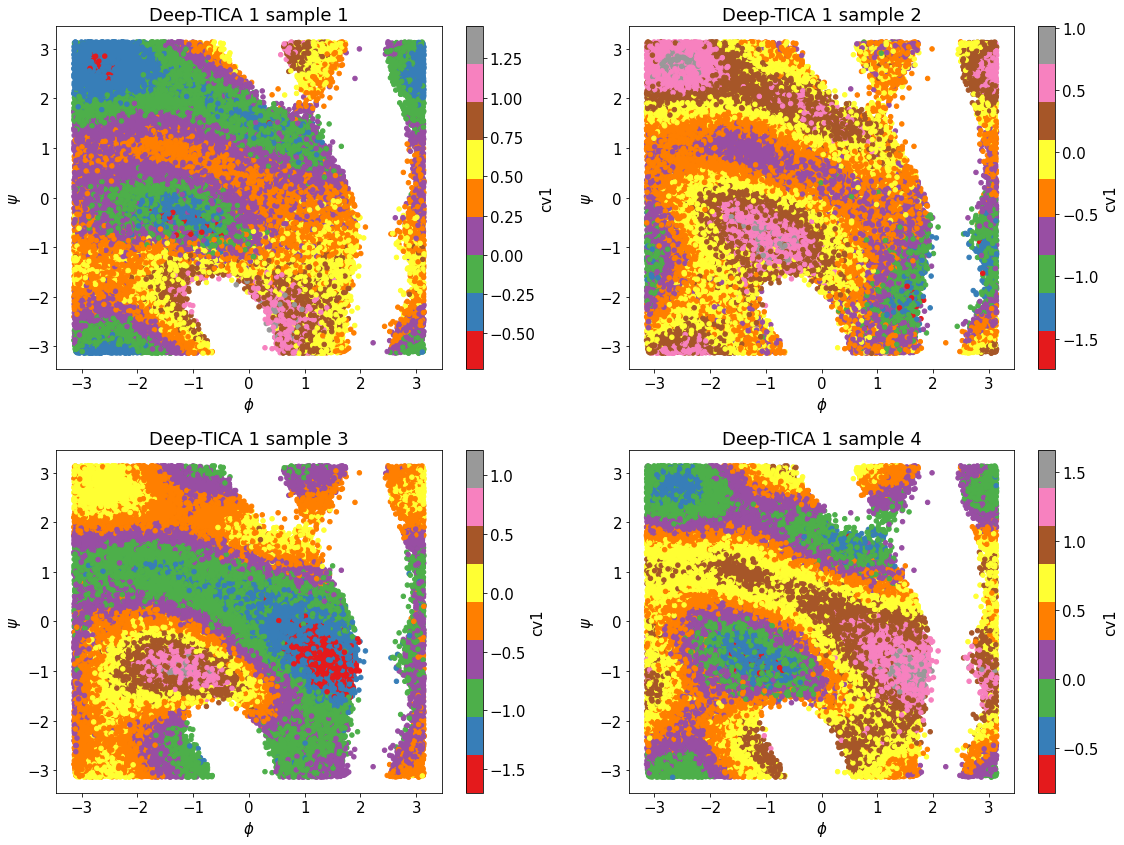

In [36]:
fig,axs1 = plt.subplots(2,2,figsize=(16,12))
fig,axs2 = plt.subplots(2,2,figsize=(16,12))

for k in range(2):
    for j in range(2):
        data["cv1"] = np.transpose(models[j+2*k](torch.Tensor(X)).detach().cpu().numpy())[0]
        data_complete["cv1"] = np.transpose(models[j+2*k](torch.Tensor(X_complete)).detach().cpu().numpy())[0]
        data.plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=axs1[k][j])
        axs1[k][j].set_xlabel(r"$\phi$")
        axs1[k][j].set_ylabel(r"$\psi$")
        axs1[k][j].set_title('Deep-TICA 1 sample '+str(1+j+2*k))
        data_complete.plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=axs2[k][j])
        axs2[k][j].set_xlabel(r"$\phi$")
        axs2[k][j].set_ylabel(r"$\psi$")
        axs2[k][j].set_title('Deep-TICA 1 sample '+str(1+j+2*k))

plt.tight_layout()


## Deep-TICA 2

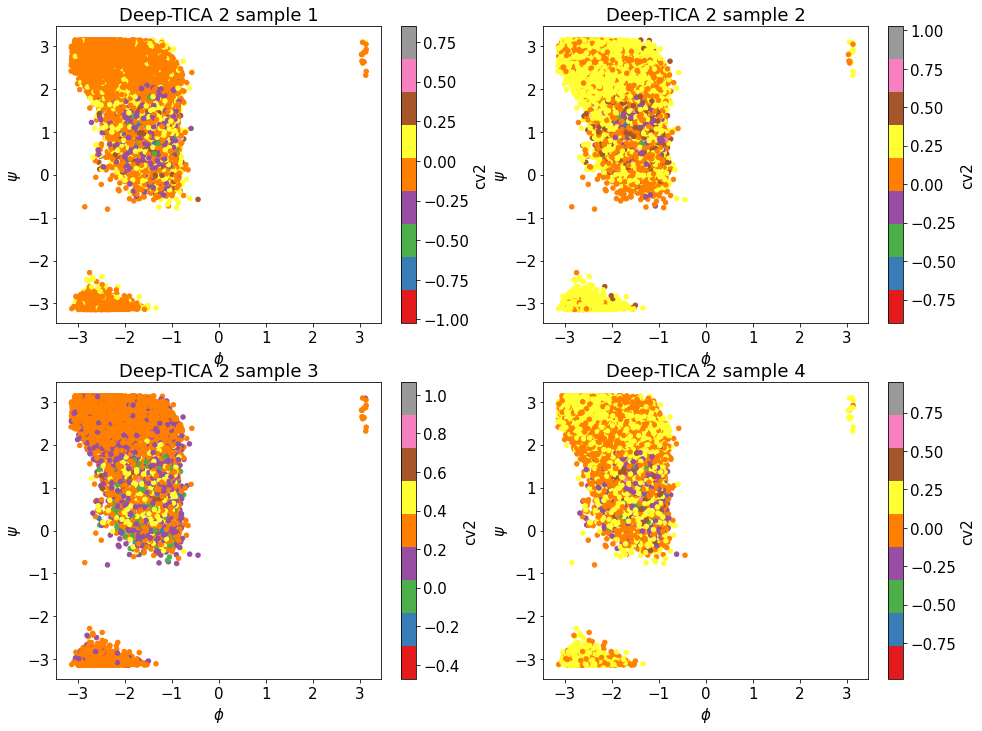

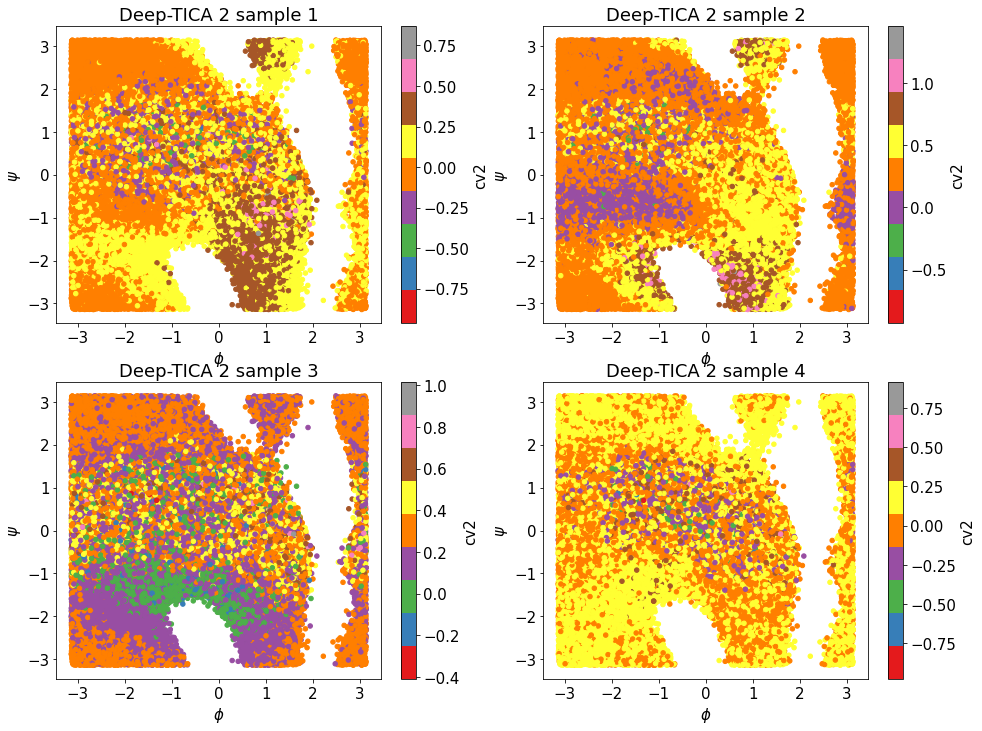

In [37]:
fig,axs1 = plt.subplots(2,2,figsize=(16,12))
fig,axs2 = plt.subplots(2,2,figsize=(16,12))

for k in range(2):
    for j in range(2):
        data["cv2"] = np.transpose(models[j+2*k](torch.Tensor(X)).detach().cpu().numpy())[1]
        data_complete["cv2"] = np.transpose(models[j+2*k](torch.Tensor(X_complete)).detach().cpu().numpy())[1]
        data.plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=axs1[k][j])
        axs1[k][j].set_xlabel(r"$\phi$")
        axs1[k][j].set_ylabel(r"$\psi$")
        axs1[k][j].set_title('Deep-TICA 2 sample '+str(1+j+2*k))
        data_complete.plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=axs2[k][j])
        axs2[k][j].set_xlabel(r"$\phi$")
        axs2[k][j].set_ylabel(r"$\psi$")
        axs2[k][j].set_title('Deep-TICA 2 sample '+str(1+j+2*k))